In [1]:
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest,SequentialFeatureSelector as SFS
from scipy.stats import chi2_contingency
from sklearn.model_selection import (
   KFold,
   RepeatedKFold,
   cross_validate,
   GridSearchCV
)
from keras import models
from keras import layers
import keras
from keras import regularizers
from keras import ops
import math
import keras_tuner as kt

In [115]:
data=pd.read_csv('Heart Attack Data Set.csv')
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
data.age.min(),data.age.max()

(29, 77)

In [4]:
bins=[29,45,60,78]
labels=['Young Adults','Middle Aged','Seniors']
data['age_category']=pd.cut(data['age'],bins=bins,labels=labels,right=False)

In [5]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,age_category
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,Seniors
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1,Young Adults
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1,Young Adults
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1,Middle Aged
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1,Middle Aged


In [6]:
for var in data.columns:
    print(var)
    print(data[var].value_counts())
    print('###########')

age
age
58    19
57    17
54    16
59    14
52    13
51    12
62    11
60    11
44    11
56    11
64    10
41    10
63     9
67     9
65     8
43     8
45     8
55     8
42     8
61     8
53     8
46     7
48     7
66     7
50     7
49     5
47     5
70     4
39     4
35     4
68     4
38     3
71     3
40     3
69     3
34     2
37     2
29     1
74     1
76     1
77     1
Name: count, dtype: int64
###########
sex
sex
1    207
0     96
Name: count, dtype: int64
###########
cp
cp
0    143
2     87
1     50
3     23
Name: count, dtype: int64
###########
trestbps
trestbps
120    37
130    36
140    32
110    19
150    17
138    13
128    12
160    11
125    11
112     9
132     8
118     7
124     6
135     6
108     6
152     5
134     5
145     5
122     4
170     4
100     4
105     3
126     3
115     3
180     3
136     3
142     3
102     2
148     2
178     2
94      2
144     2
146     2
200     1
114     1
154     1
123     1
192     1
174     1
165     1
104     1
117     1
101

In [7]:
categorical_var=['sex','cp','fbs','exang','restecg','slope','ca','thal','age_category']
numrical_var=['age','trestbps','chol','thalach','oldpeak',]

<Axes: xlabel='sex', ylabel='Count'>

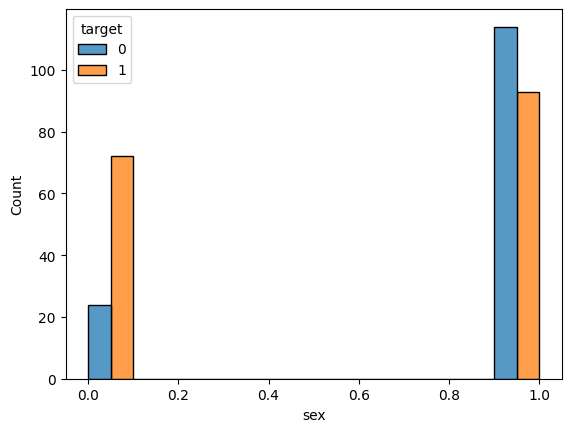

In [8]:
sns.histplot(data=data,x='sex',hue='target',multiple='dodge')

<Axes: xlabel='trestbps', ylabel='thalach'>

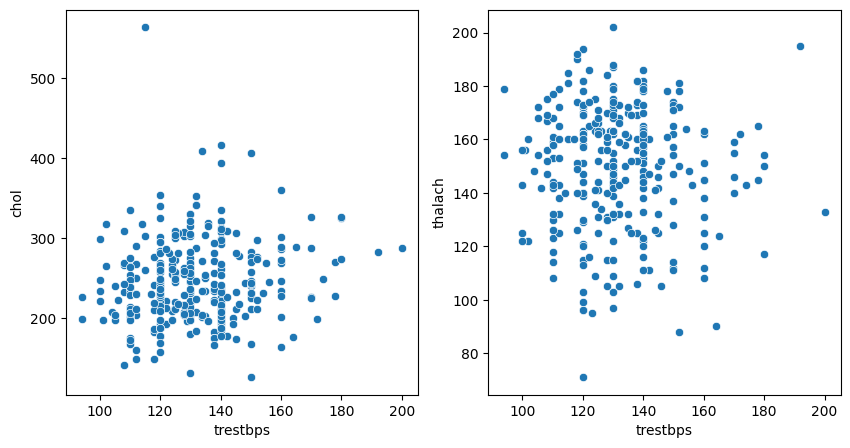

In [9]:
fig=plt.figure(figsize=(10,5))
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
sns.scatterplot(data=data,x='trestbps',y='chol',ax=ax1)
sns.scatterplot(data=data,x='trestbps',y='thalach',ax=ax2)

In [10]:
data.groupby(['age_category','target'],observed=False)['target'].agg(['count'])

count
age_category target       
Young Adults 0          14
             1          42
Middle Aged  0          72
             1          85
Seniors      0          52
             1          38

In [11]:
data.groupby(['sex','target'],observed=False)['target'].agg(['count'])

count
sex target       
0   0          24
    1          72
1   0         114
    1          93

In [12]:
data.chol.min(),data.chol.max()

(126, 564)

In [13]:
chol_gt_300=data[data['chol']>300]
chol_gt_300.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,age_category
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1,Middle Aged
16,58,0,2,120,340,0,1,172,0,0.0,2,0,2,1,Middle Aged
25,71,0,1,160,302,0,1,162,0,0.4,2,2,2,1,Seniors
28,65,0,2,140,417,1,0,157,0,0.8,2,1,2,1,Seniors
36,54,0,2,135,304,1,1,170,0,0.0,2,0,2,1,Middle Aged


In [14]:
chol_gt_300.groupby(['age_category','target'],observed=False)['target'].agg(['count'])

count
age_category target       
Young Adults 0           2
             1           4
Middle Aged  0          10
             1           9
Seniors      0           8
             1          10

<Axes: ylabel='count'>

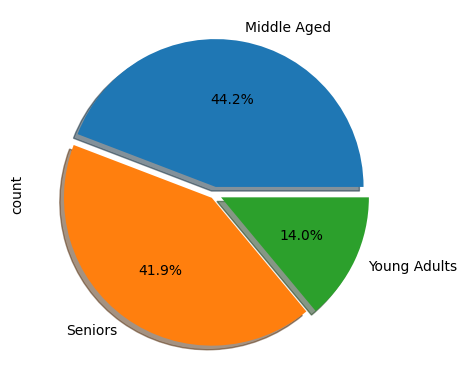

In [15]:
chol_gt_300['age_category'].value_counts().plot(kind='pie',
                                               autopct='%1.1f%%',
                                               shadow=True,
                                               explode=[0.05,0.03,0.05])

<Axes: ylabel='count'>

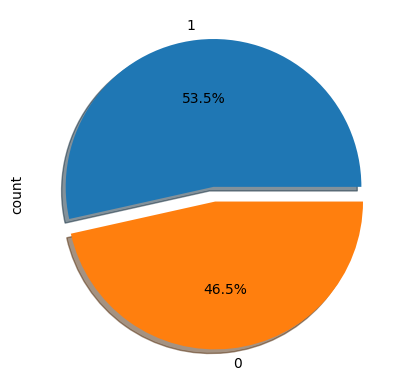

In [16]:
chol_gt_300['target'].value_counts().plot(kind='pie',
                                         autopct='%1.1f%%',
                                         shadow=True,
                                         explode=[0.05,0.05])

##### Fbs is the fasting blood sugar level; the value is assigned as 1 if the fasting blood sugar is below 120 mg/dl and 0 if it is above.

In [17]:
chol_gt_300.groupby(['fbs','target'])['target'].agg(['count'])

count
fbs target       
0   0          17
    1          21
1   0           3
    1           2

In [18]:
age_category_mappings={
    'Young Adults':0,
    'Middle Aged':1,
    'Seniors':2
}
data['age_category']=data['age_category'].map(age_category_mappings)
data['age_category'].head()

0    2
1    0
2    0
3    1
4    1
Name: age_category, dtype: category
Categories (3, int64): [0 < 1 < 2]

In [19]:
def categorize_blood_pressure(df):
    bins=[94,130,140,180,201]
    labels=['Prehypertension','Hypertension Stage 1','Hypertension Stage 2','Hypertensive Crisis']
    df['bp_category']=pd.cut(df['trestbps'],bins=bins,labels=labels,right=False)
    return df


In [20]:
def categorize_cholesterol(df):
    bins=[125,160,190,565]
    labels=['Borderline High','High','Very High']
    df['chol_category']=pd.cut(df['chol'],bins=bins,labels=labels,right=False)
    return df

In [21]:
def categorized_thalach(df):
    bins=[70,100,140,180,203]
    labels=['Low','Moderate','High','Very High']
    df['thalach_category']=pd.cut(df['thalach'],bins=bins,labels=labels,right=False)
    return df

In [22]:
def categorized_oldpeak(df):
    bins=[0.0,0.6,1.6,2.6,6.3]
    labels=['Nornal/Minimal','Mild','Modarate','Severe']
    df['oldpeak_category']=pd.cut(df['oldpeak'],bins=bins,labels=labels,right=False)
    return df

In [23]:
eda=data.copy()

In [24]:
eda=categorize_blood_pressure(eda)
eda=categorize_cholesterol(eda)
eda=categorized_thalach(eda)
eda=categorized_oldpeak(eda)

In [25]:
age_category_mappings={
    0:'Young Adults',
    1:'Middle Aged',
    2:'Seniors'
}
eda['age_category']=eda['age_category'].map(age_category_mappings)

In [26]:
target_mappings={
    1:'Heart Attack',
    0:'No Heart Attack'
}
eda['target']=eda['target'].map(target_mappings)

In [27]:
sex_mappings={
    0:'Female',
    1:'Male'
}
eda['sex']=eda['sex'].map(sex_mappings)

In [28]:
eda.groupby(['sex','target'])['target'].count()

sex     target         
Female  Heart Attack        72
        No Heart Attack     24
Male    Heart Attack        93
        No Heart Attack    114
Name: target, dtype: int64

In [29]:
eda.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,age_category,bp_category,chol_category,thalach_category,oldpeak_category
0,63,Male,3,145,233,1,0,150,0,2.3,0,0,1,Heart Attack,Seniors,Hypertension Stage 2,Very High,High,Modarate
1,37,Male,2,130,250,0,1,187,0,3.5,0,0,2,Heart Attack,Young Adults,Hypertension Stage 1,Very High,Very High,Severe
2,41,Female,1,130,204,0,0,172,0,1.4,2,0,2,Heart Attack,Young Adults,Hypertension Stage 1,Very High,High,Mild
3,56,Male,1,120,236,0,1,178,0,0.8,2,0,2,Heart Attack,Middle Aged,Prehypertension,Very High,High,Mild
4,57,Female,0,120,354,0,1,163,1,0.6,2,0,2,Heart Attack,Middle Aged,Prehypertension,Very High,High,Mild


In [30]:
eda.groupby(['age_category','target'],observed=False)['target'].agg(['count'])

count
age_category target                
Young Adults Heart Attack        42
             No Heart Attack     14
Middle Aged  Heart Attack        85
             No Heart Attack     72
Seniors      Heart Attack        38
             No Heart Attack     52

<Axes: xlabel='thalach_category', ylabel='Count'>

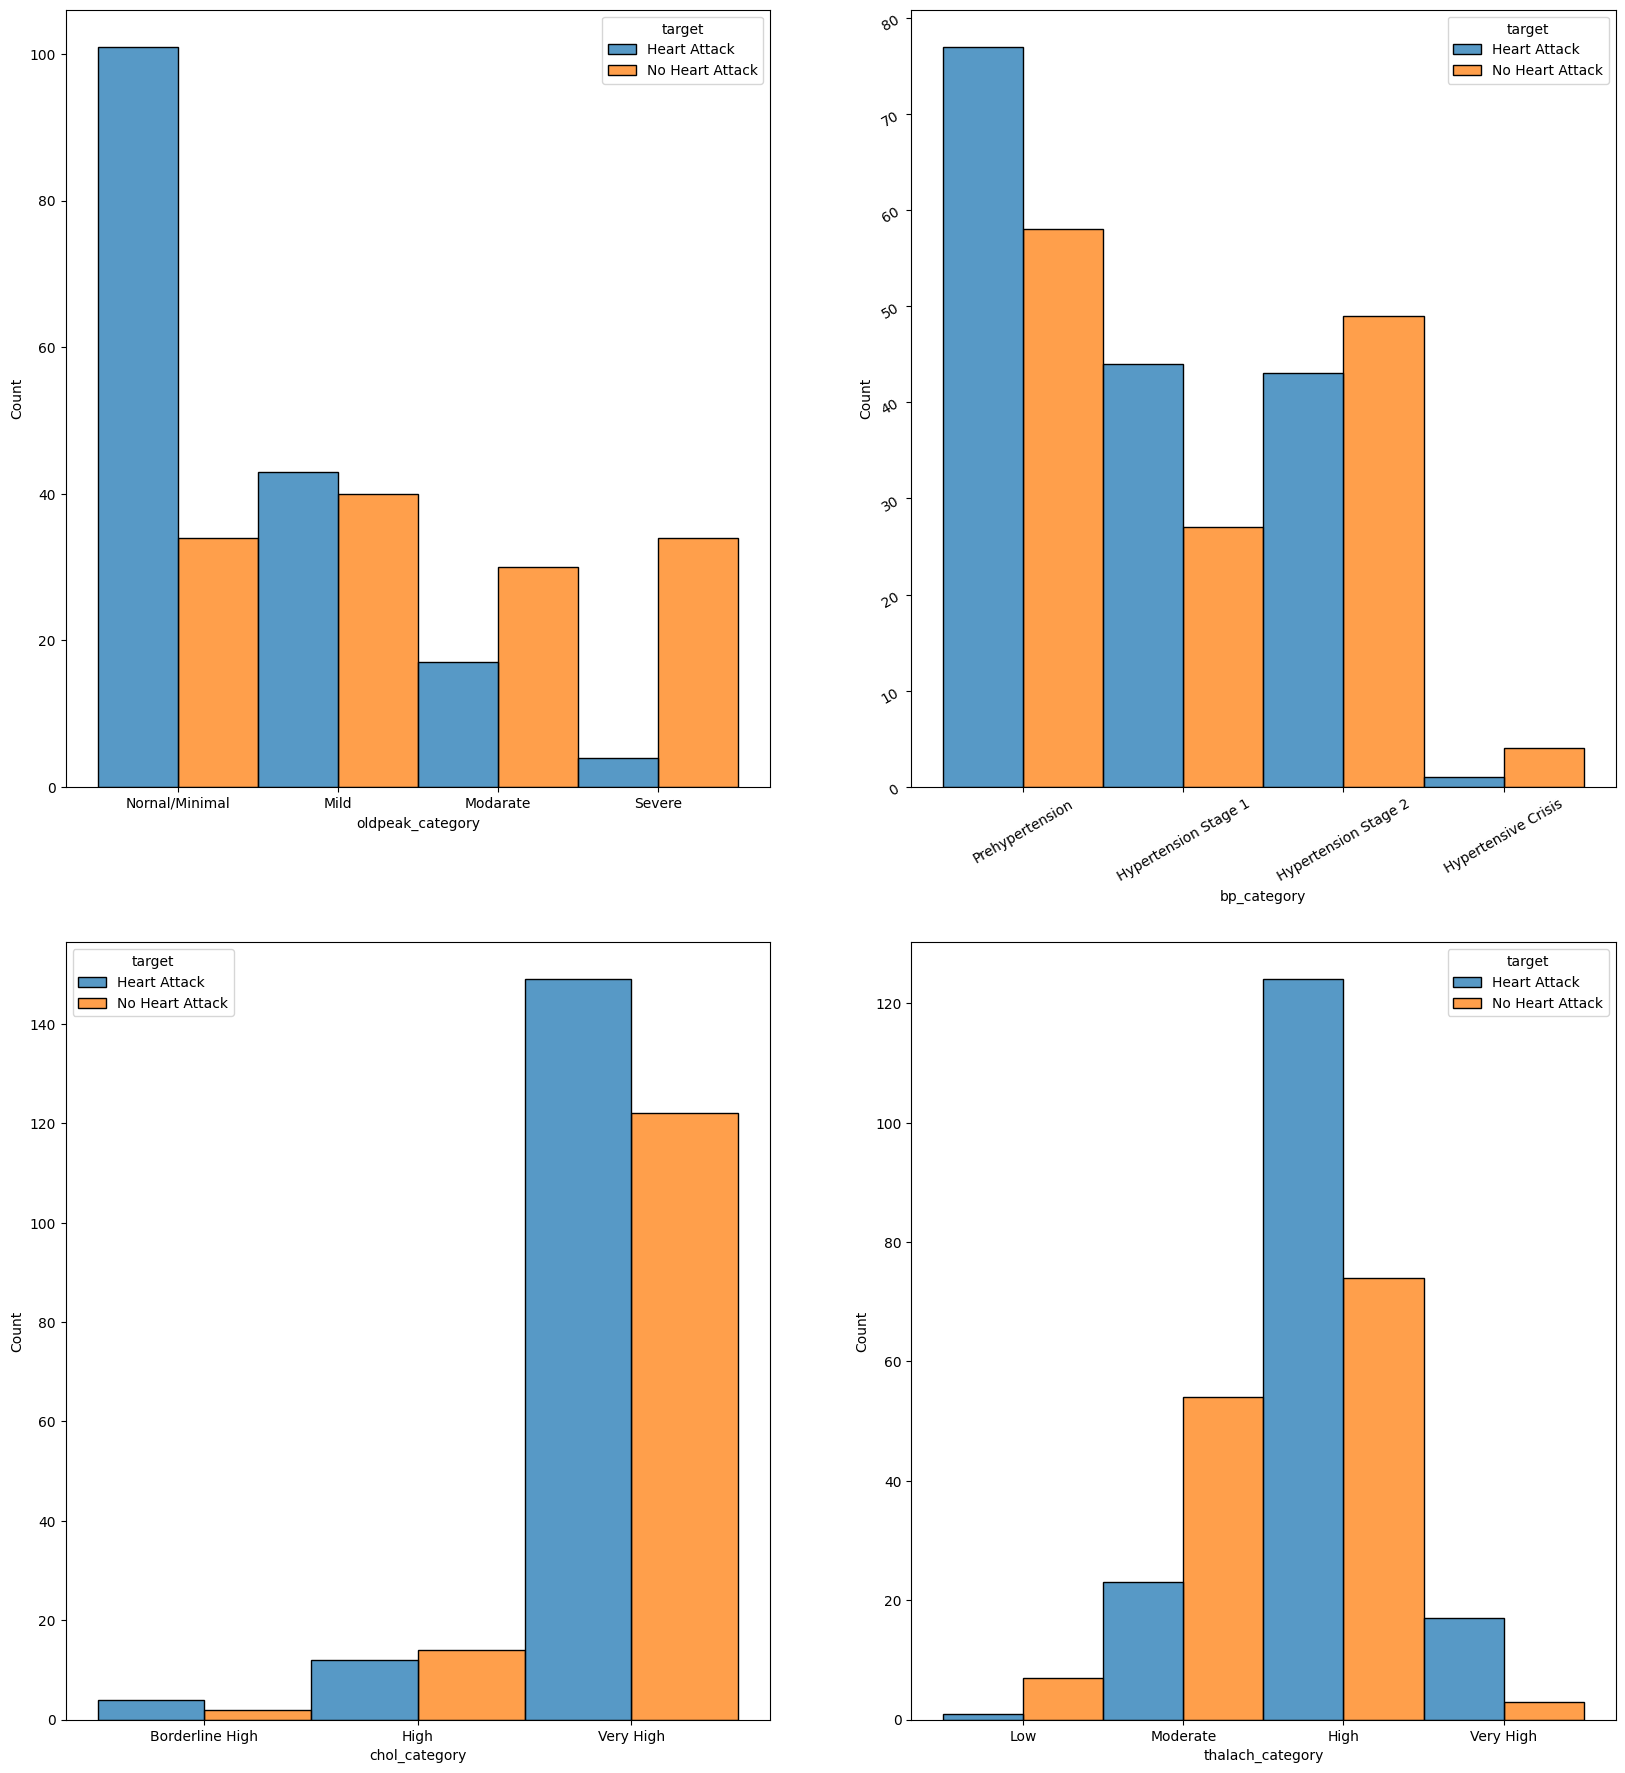

In [31]:
fig=plt.figure(figsize=(20,15))
ax1=fig.add_subplot(2,2,1)
ax2=fig.add_subplot(2,2,2)
ax2.tick_params(labelrotation=30)
ax3=fig.add_subplot(2,2,3)
ax4=fig.add_subplot(2,2,4)
fig.subplots_adjust(top=1.25)
sns.histplot(data=eda,x='oldpeak_category',hue='target',multiple='dodge',ax=ax1)
sns.histplot(data=eda,x='bp_category',hue='target',multiple='dodge',ax=ax2)
sns.histplot(data=eda,x='chol_category',hue='target',multiple='dodge',ax=ax3)
sns.histplot(data=eda,x='thalach_category',hue='target',multiple='dodge',ax=ax4)

#### <center>Machine Learning</center>


In [32]:
X_train,X_test,y_train,y_test=train_test_split(
    data.drop('target',axis=1),
    data['target'],
    test_size=0.3,
    random_state=0
)

In [33]:
X_train.shape,X_test.shape

((212, 14), (91, 14))

In [34]:
data[categorical_var]

,sex,cp,fbs,exang,restecg,slope,ca,thal,age_category
0,1,3,1,0,0,0,0,1,2
1,1,2,0,0,1,0,0,2,0
2,0,1,0,0,0,2,0,2,0
3,1,1,0,0,1,2,0,2,1
4,0,0,0,1,1,2,0,2,1
...,...,...,...,...,...,...,...,...,...
298,0,0,0,1,1,1,0,3,1
299,1,3,0,0,1,1,0,3,1
300,1,0,1,0,1,1,2,3,2
301,1,0,0,1,1,1,1,3,1


In [35]:
data[numrical_var]

,age,trestbps,chol,thalach,oldpeak
0,63,145,233,150,2.3
1,37,130,250,187,3.5
2,41,130,204,172,1.4
3,56,120,236,178,0.8
4,57,120,354,163,0.6
...,...,...,...,...,...
298,57,140,241,123,0.2
299,45,110,264,132,1.2
300,68,144,193,141,3.4
301,57,130,131,115,1.2


In [36]:
X_train_scaled,X_test_scaled,y_train,y_test=train_test_split(data.drop(['target'],axis=1),
                                                            data['target'],
                                                            test_size=0.3,
                                                            random_state=0)


array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'trestbps'}>],
       [<Axes: title={'center': 'chol'}>,
        <Axes: title={'center': 'thalach'}>],
       [<Axes: title={'center': 'oldpeak'}>, <Axes: >]], dtype=object)

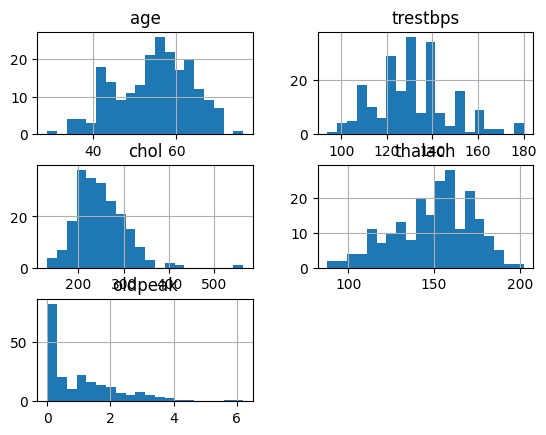

In [37]:
X_train_scaled[numrical_var].hist(bins=20)

In [38]:
scaler=StandardScaler().set_output(transform='pandas')
scaler.fit(X_train_scaled[numrical_var])
X_train_num_scaled=scaler.transform(X_train_scaled[numrical_var])
X_test_num_scaled=scaler.transform(X_test_scaled[numrical_var])


In [39]:
X_train_scaled=pd.concat([X_train_scaled[categorical_var],X_train_num_scaled],axis=1)
X_test_scaled=pd.concat([X_test_scaled[categorical_var],X_test_num_scaled],axis=1)

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'trestbps'}>],
       [<Axes: title={'center': 'chol'}>,
        <Axes: title={'center': 'thalach'}>],
       [<Axes: title={'center': 'oldpeak'}>, <Axes: >]], dtype=object)

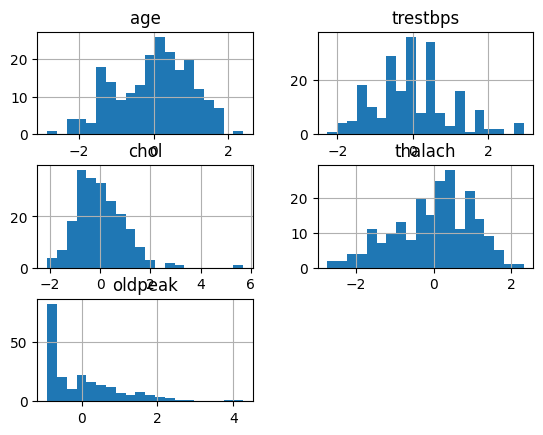

In [40]:
X_train_scaled[numrical_var].hist(bins=20)

In [41]:
X_train_scaled.shape,X_test_scaled.shape

((212, 14), (91, 14))

#### Machine Learning Algorithms

In [42]:
def runLogisticRegreesion(X_train,X_test,y_train,y_test):
    lr=LogisticRegression(random_state=0)
    lr.fit(X_train,y_train)
    print('Training set')
    y_pred=lr.predict(X_train)
    print('Logisitic Regression Training accuracy: {}'.format(accuracy_score(y_train,y_pred)))
    print('Testing set')
    y_pred=lr.predict(X_test)
    print('Logisitic Regression Testing accuracy: {}'.format(accuracy_score(y_test,y_pred)))
    cm=confusion_matrix(y_test,y_pred)
    df=pd.DataFrame(cm,index=['No heart disease','heart disease'],columns=['No heart disease','heart disease'])
    sns.heatmap(df,annot=True,cbar=None,cmap='Blues')
    plt.title('Confusion matrix')
    plt.ylabel('True Class')
    plt.xlabel('Prediction Class')
    plt.show()

In [43]:
def runLogisticRegressionRegularization(X_train,X_test,y_train,y_test):
    lrr=LogisticRegression(C=0.1,penalty='l2',solver='lbfgs',max_iter=100)
    lrr.fit(X_train,y_train)
    print('Training set')
    y_pred=lrr.predict(X_train)
    print('Logisitic Regression Regularization training accuracy: {}'.format(accuracy_score(y_train,y_pred)))
    print('Testing set')
    y_pred=lrr.predict(X_test)
    print('Logisitic Regression Regularization testing accuracy : {}'.format(accuracy_score(y_test,y_pred)))
    print('Confusion Metrics')
    cm=confusion_matrix(y_test,y_pred)
    df=pd.DataFrame(cm,index=['No heart disease','heart disease'],columns=['No heart disease','heart disease'])
    sns.heatmap(df,annot=True,cbar=None,cmap='Blues')
    plt.title('Confusion matrix')
    plt.ylabel('True Class')
    plt.xlabel('Predication Class')
    plt.show()

In [44]:
def runDecisionTreeClassifier(X_train,X_test,y_train,y_test):
    dt=DecisionTreeClassifier(random_state=0)
    dt.fit(X_train,y_train)
    print('Training set')
    y_pred=dt.predict(X_train)
    print('Decision Tree  Classifier Training accuracy: {}'.format(accuracy_score(y_train,y_pred)))
    print('Test set')
    y_pred=dt.predict(X_test)
    print('Descision Tree  Classifier Test accuracy: {}'.format(accuracy_score(y_test,y_pred)))
    cm=confusion_matrix(y_test,y_pred)
    df=pd.DataFrame(cm,index=['No heart disease','heart disease'],columns=['No heart disease','heart disease'])
    sns.heatmap(df,annot=True,cbar=None,cmap='Blues')
    plt.title('Confusion matrix')
    plt.ylabel('True Class')
    plt.xlabel('Predication Class')
    plt.show()

In [45]:
def runRandomForestClassifier(X_train,X_test,y_train,y_test):
    rf=RandomForestClassifier(n_estimators=100)
    rf.fit(X_train,y_train)
    print('Training set')
    y_pred=rf.predict(X_train)
    print('Random Forest Training accuracy : {}'.format(accuracy_score(y_train,y_pred)))
    print('Test set')
    y_pred=rf.predict(X_test)
    print('Random Forest Test accuracy: {}'.format(accuracy_score(y_test,y_pred)))
    cm=confusion_matrix(y_test,y_pred)
    df=pd.DataFrame(cm,index=['No heart disease','heart disease'],columns=['No heart disease','heart disease'])
    sns.heatmap(df,annot=True,cbar=None,cmap='Blues')

Training set
Logisitic Regression Training accuracy: 0.8490566037735849
Testing set
Logisitic Regression Testing accuracy: 0.8131868131868132


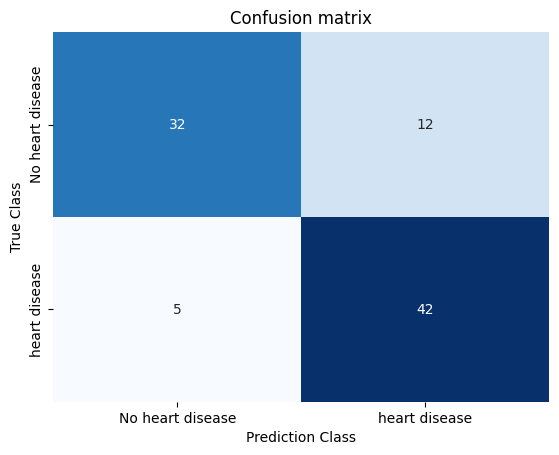

In [46]:
runLogisticRegreesion(X_train_scaled,X_test_scaled,y_train,y_test)

Training set
Logisitic Regression Regularization training accuracy: 0.8584905660377359
Testing set
Logisitic Regression Regularization testing accuracy : 0.8241758241758241
Confusion Metrics


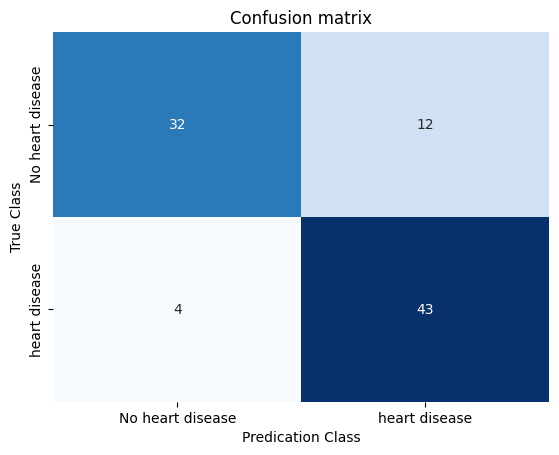

In [47]:
runLogisticRegressionRegularization(X_train_scaled,X_test_scaled,y_train,y_test)

Training set
Decision Tree  Classifier Training accuracy: 1.0
Test set
Descision Tree  Classifier Test accuracy: 0.7252747252747253


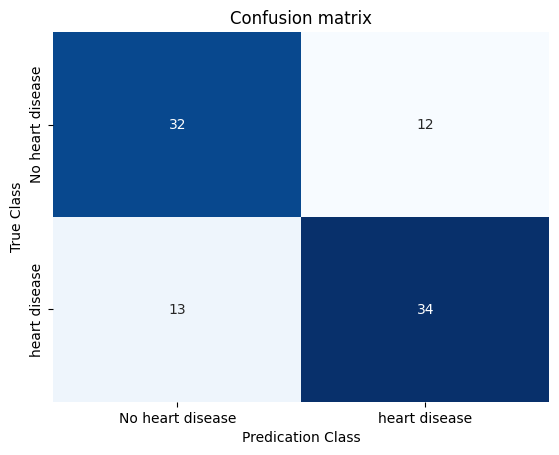

In [48]:
runDecisionTreeClassifier(X_train,X_test,y_train,y_test)

Training set
Random Forest Training accuracy : 1.0
Test set
Random Forest Test accuracy: 0.8351648351648352


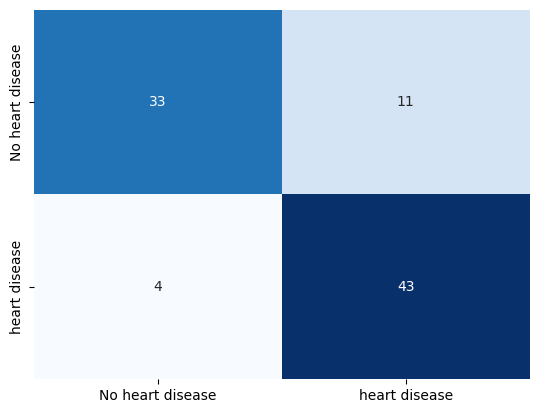

In [49]:
runRandomForestClassifier(X_train,X_test,y_train,y_test)

In [50]:
X_train_stats,X_test_stats=X_train.copy(),X_test.copy()
X_train_stats.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,age_category
137,62,1,1,128,208,1,0,140,0,0.0,2,0,2,2
106,69,1,3,160,234,1,0,131,0,0.1,1,1,2,2
284,61,1,0,140,207,0,0,138,1,1.9,2,1,3,2
44,39,1,2,140,321,0,0,182,0,0.0,2,0,2,0
139,64,1,0,128,263,0,1,105,1,0.2,1,1,3,2


#### Convert continues variables into some categorical variables for statistical test for feature selection

##### convert trestbps into ordinal variable

In [51]:
def categorize_blood_pressure(df):
    bins=[94,130,140,180,201]
    labels=['Prehypertension','Hypertension Stage 1','Hypertension Stage 2','Hypertensive Crisis']
    df['bp_category']=pd.cut(df['trestbps'],bins=bins,labels=labels,right=False)
    return df

X_train_stats=categorize_blood_pressure(X_train_stats)
X_test_stats=categorize_blood_pressure(X_test_stats)

In [52]:
bp_category_mapping={
    'Prehypertension':0,
    'Hypertension Stage 1':1,
    'Hypertension Stage 2':2,
    'Hypertensive Crisis':3
}
X_train_stats['bp_category']=X_train_stats['bp_category'].map(bp_category_mapping)
X_test_stats['bp_category']=X_test_stats['bp_category'].map(bp_category_mapping)

##### Convert cholesterol into ordinal variable

In [53]:
def categorize_cholesterol(df):
    bins=[125,160,190,565]
    labels=['Borderline High','High','Very High']
    df['chol_category']=pd.cut(df['chol'],bins=bins,labels=labels,right=False)
    return df

X_train_stats=categorize_cholesterol(X_train_stats)
X_test_stats=categorize_cholesterol(X_test_stats)

In [54]:
chol_mappings={
    'Borderline High':0,
    'High':1,
    'Very High':2
}
X_train_stats['chol_category']=X_train_stats['chol_category'].map(chol_mappings)
X_test_stats['chol_category']=X_test_stats['chol_category'].map(chol_mappings)

##### thalach (maximum heart rate achieved) into ordinal variables

In [55]:
def categorized_thalach(df):
    bins=[70,100,140,180,203]
    labels=['Low','Moderate','High','Very High']
    df['thalach_category']=pd.cut(df['thalach'],bins=bins,labels=labels,right=False)
    return df

X_train_stats=categorized_thalach(X_train_stats)
X_test_stats=categorized_thalach(X_test_stats)

In [56]:
thalach_mappings={
    'Low':0,
    'Moderate':1,
    'High':2,
    'Very High':3
}
X_train_stats['thalach_category']=X_train_stats['thalach_category'].map(thalach_mappings)
X_test_stats['thalach_category']=X_test_stats['thalach_category'].map(thalach_mappings)

##### Convert Oldpeak ST depression induced by exercise relative to rest, a crucial measurement in cardiac stress tests.  into Ordinal Variable

In [57]:
def categorized_oldpeak(df):
    bins=[0.0,0.6,1.6,2.6,6.3]
    labels=['Nornal/Minimal','Mild','Modarate','Severe']
    df['oldpeak_category']=pd.cut(df['oldpeak'],bins=bins,labels=labels,right=False)
    return df
X_train_stats=categorized_oldpeak(X_train_stats)
X_test_stats=categorized_oldpeak(X_test_stats)

In [58]:
oldpeak_mappings={
    'Nornal/Minimal':0,
    'Mild':1,
    'Modarate':2,
    'Severe':3
}
X_train_stats['oldpeak_category']=X_train_stats['oldpeak_category'].map(oldpeak_mappings)
X_test_stats['oldpeak_category']=X_test_stats['oldpeak_category'].map(oldpeak_mappings)

In [59]:
ordinal_var=['bp_category','chol_category','thalach_category','oldpeak_category']
X_train_scaled=pd.concat([X_train_scaled,X_train_stats[ordinal_var]],axis=1)
X_test_scaled=pd.concat([X_test_scaled,X_test_stats[ordinal_var]],axis=1)

Training set
Logisitic Regression Training accuracy: 0.8537735849056604
Testing set
Logisitic Regression Testing accuracy: 0.8241758241758241


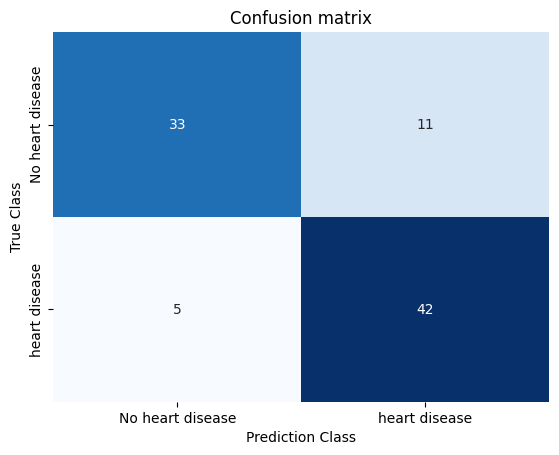

In [60]:
runLogisticRegreesion(X_train_scaled,X_test_scaled,y_train,y_test)

Training set
Logisitic Regression Regularization training accuracy: 0.8584905660377359
Testing set
Logisitic Regression Regularization testing accuracy : 0.8351648351648352
Confusion Metrics


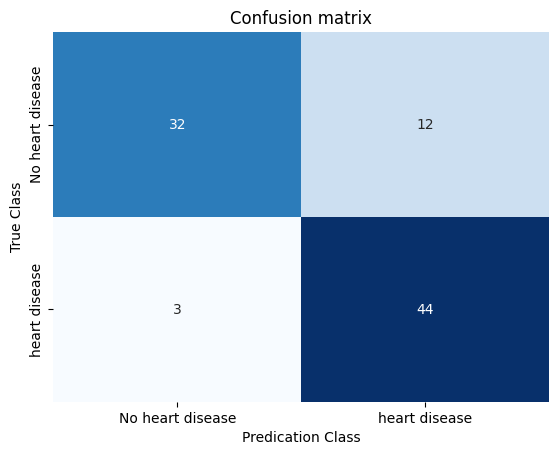

In [61]:
runLogisticRegressionRegularization(X_train_scaled,X_test_scaled,y_train,y_test)

##### Hyperparameter tuning -> cross validation

In [62]:
logit=LogisticRegression(penalty='l2',solver='liblinear',random_state=0,max_iter=200)
kf=KFold(n_splits=5,shuffle=True,random_state=0)
clf=cross_validate(logit,X_train_scaled,y_train,scoring='accuracy',return_train_score=True,cv=kf)
print('Training set Accuracy:',np.mean(clf['train_score']),'+/-',np.std(clf['train_score']))
print('Testing set Accuracy:',np.mean(clf['test_score']),'+/-',np.std(clf['test_score']))

Training set Accuracy: 0.8632231117298991 +/- 0.011829007222741932
Testing set Accuracy: 0.7925802879291253 +/- 0.03721754114346968


Training set
Decision Tree  Classifier Training accuracy: 1.0
Test set
Descision Tree  Classifier Test accuracy: 0.7142857142857143


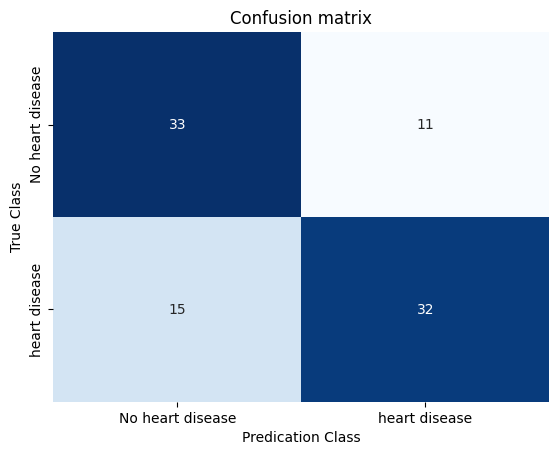

In [63]:
runDecisionTreeClassifier(X_train_stats,X_test_stats,y_train,y_test)

Training set
Random Forest Training accuracy : 1.0
Test set
Random Forest Test accuracy: 0.8241758241758241


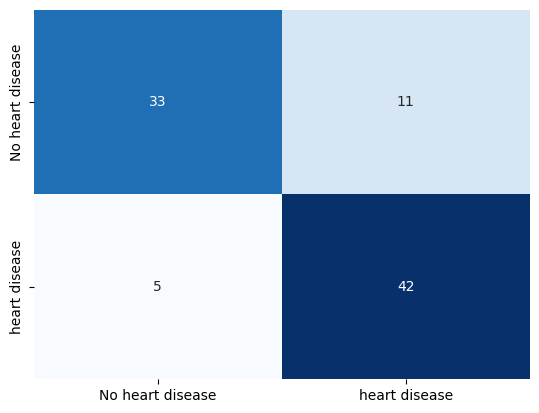

In [64]:
runRandomForestClassifier(X_train_stats,X_test_stats,y_train,y_test)

In [65]:
rfcv=RandomForestClassifier(n_estimators=100,max_depth=6,random_state=0)
kf=KFold(n_splits=5,shuffle=True,random_state=0)
clf=cross_validate(rfcv,X_train_stats,y_train,cv=kf,scoring='accuracy',return_train_score=True)
print('Random Forest CV accuracy:',np.mean(clf['train_score']),'+/-',np.std(clf['test_score']))
print('Random Forest CV accuracy:',np.mean(clf['test_score']),'+/-',np.std(clf['test_score']))

Random Forest CV accuracy: 0.984671075530804 +/- 0.0257493539390186
Random Forest CV accuracy: 0.8162790697674417 +/- 0.0257493539390186


### Feature Selection

In [66]:
X_train_fs=X_train_stats.drop(['age','cp','trestbps','chol','thalach','oldpeak'],axis=1)
X_test_fs=X_test_stats.drop(['age','cp','trestbps','chol','thalach','oldpeak'],axis=1)

#### 1. Statistical Test For Feature Selection

#### 1.1 Mutual Information

Text(0, 0.5, 'Mutual Information')

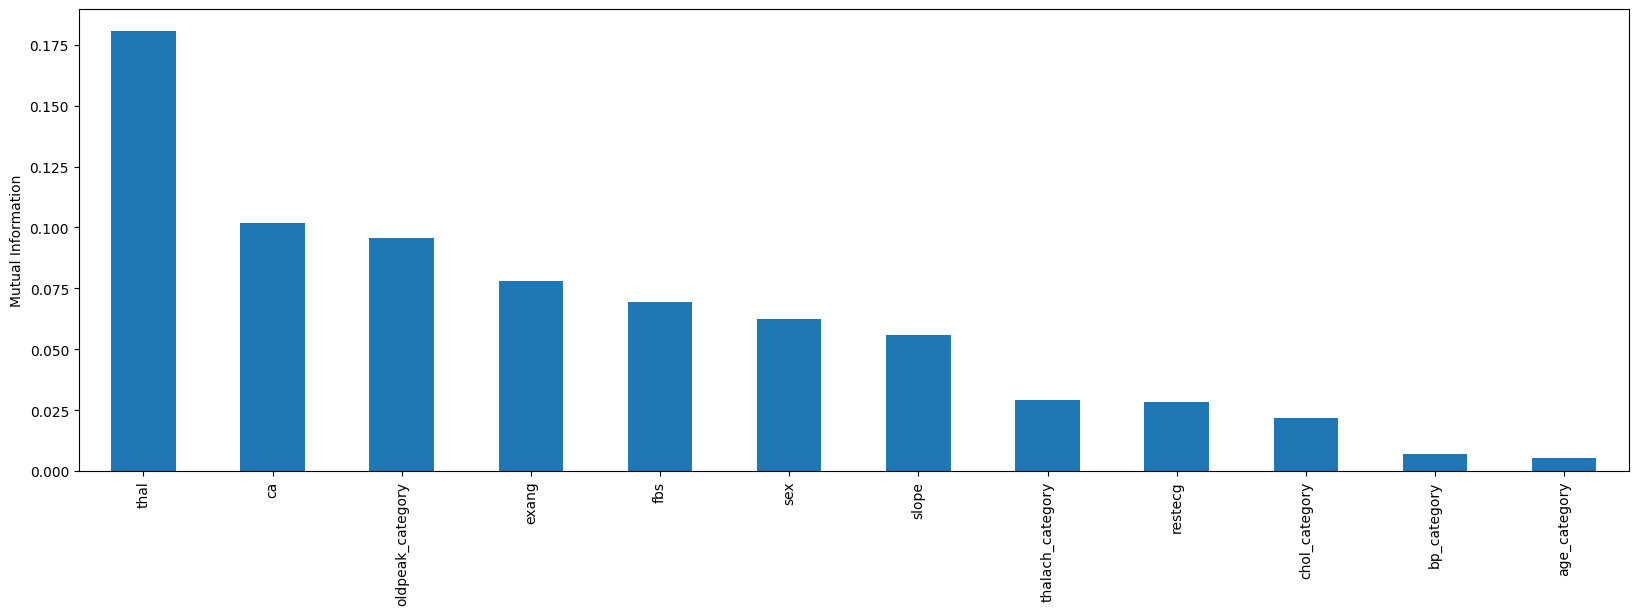

In [67]:
mi=mutual_info_classif(X=X_train_fs,y=y_train,discrete_features=False,n_neighbors=3,random_state=0)
mi=pd.Series(mi)
mi.index=X_train_fs.columns
mi.sort_values(ascending=False).plot.bar(figsize=(20,6))
plt.ylabel('Mutual Information')

In [68]:
sel_=SelectKBest(mutual_info_classif,k=10).fit(X_train_fs,y_train)
X_train_fs.columns[sel_.get_support()]

Index(['sex', 'fbs', 'exang', 'slope', 'ca', 'thal', 'age_category',
       'chol_category', 'thalach_category', 'oldpeak_category'],
      dtype='object')

In [69]:
X_train_mi=sel_.transform(X_train_fs)
X_test_mi=sel_.transform(X_test_fs)

Training set
Logisitic Regression Training accuracy: 0.8113207547169812
Testing set
Logisitic Regression Testing accuracy: 0.7912087912087912


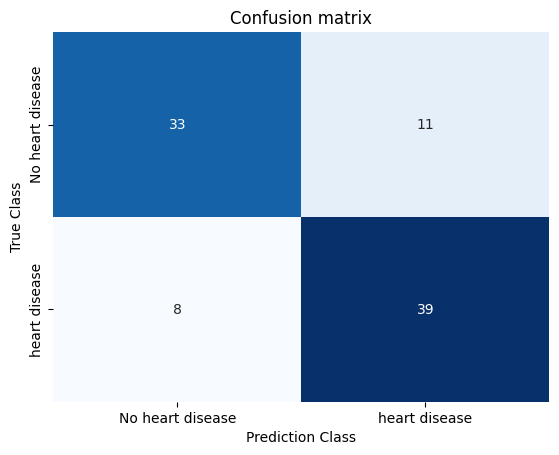

In [70]:
runLogisticRegreesion(X_train_mi,X_test_mi,y_train,y_test)

In [71]:
logit=LogisticRegression(penalty='l2',solver='liblinear',C=1,max_iter=200,random_state=0)
kf=KFold(n_splits=5,shuffle=True,random_state=0)
clf=cross_validate(logit,X_train_mi,y_train,cv=kf,scoring='accuracy',return_train_score=True)
print('Mutual Information Logistic Regression accuracy:',np.mean(clf['train_score']),'+/-',np.std(clf['test_score']))
print('Mutual Information Logistic Regression accuracy:',np.mean(clf['test_score']),'+/-',np.std(clf['test_score']))

Mutual Information Logistic Regression accuracy: 0.8160389836407937 +/- 0.04662223835546719
Mutual Information Logistic Regression accuracy: 0.8017718715393134 +/- 0.04662223835546719


##### Grid Search CV

In [72]:
param_grid=dict(
    penalty=['l1','l2'],
    C=[0.1,1,10]
    )
clf=GridSearchCV(estimator=logit,param_grid=param_grid,scoring='accuracy',cv=kf,refit=True)
search=clf.fit(X_train_mi,y_train)
search.best_params_

{'C': 1, 'penalty': 'l2'}

Training set
Logisitic Regression Regularization training accuracy: 0.8066037735849056
Testing set
Logisitic Regression Regularization testing accuracy : 0.8131868131868132
Confusion Metrics


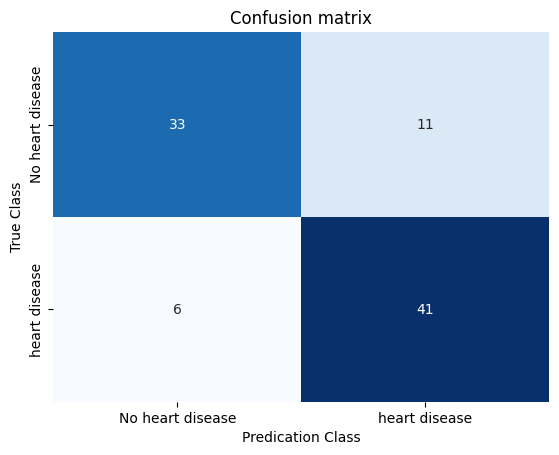

In [73]:
runLogisticRegressionRegularization(X_train_mi,X_test_mi,y_train,y_test)

Training set
Decision Tree  Classifier Training accuracy: 0.9811320754716981
Test set
Descision Tree  Classifier Test accuracy: 0.7032967032967034


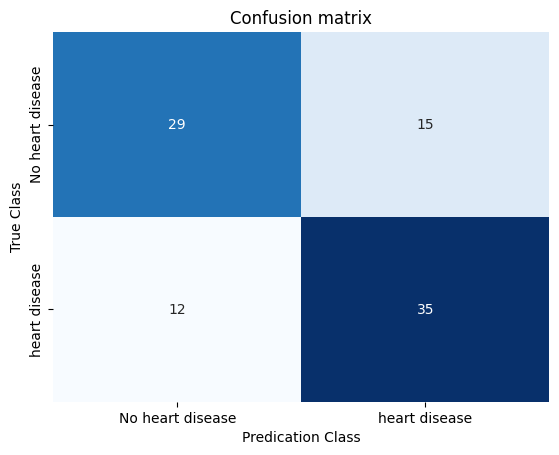

In [74]:
runDecisionTreeClassifier(X_train_mi,X_test_mi,y_train,y_test)

Training set
Random Forest Training accuracy : 0.9811320754716981
Test set
Random Forest Test accuracy: 0.8131868131868132


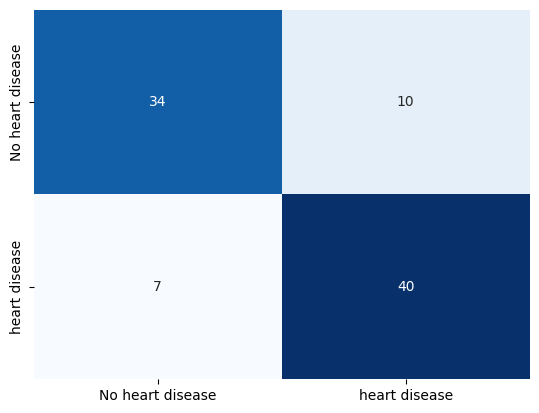

In [75]:
runRandomForestClassifier(X_train_mi,X_test_mi,y_train,y_test)

In [76]:
rfcv=RandomForestClassifier(n_estimators=100,max_depth=6,random_state=0)
kf=KFold(n_splits=5,shuffle=True,random_state=0)
clf=cross_validate(rfcv,X_train_mi,y_train,cv=kf,scoring='accuracy',return_train_score=True)
print('Random Forest CV training set accuracy:',np.mean(clf['train_score']),'+/-',np.std(clf['train_score']))
print('Random forest CV testing set accuracy:',np.mean(clf['test_score']),'+/-',np.std(clf['test_score']))

Random Forest CV training set accuracy: 0.9339644970414203 +/- 0.011990986093888401
Random forest CV testing set accuracy: 0.7738648947951273 +/- 0.06301072190786196


In [77]:
param_grid=dict(n_estimators=[100,200,600],max_depth=[4,6,8,10])
clf=GridSearchCV(estimator=rfcv,param_grid=param_grid,scoring='accuracy',cv=kf)
search=clf.fit(X_train_mi,y_train)
search.best_params_

{'max_depth': 4, 'n_estimators': 100}

#### 1.2 Chi-Square Test

Text(0.5, 1.0, 'Feature Importance based on chi=square test')

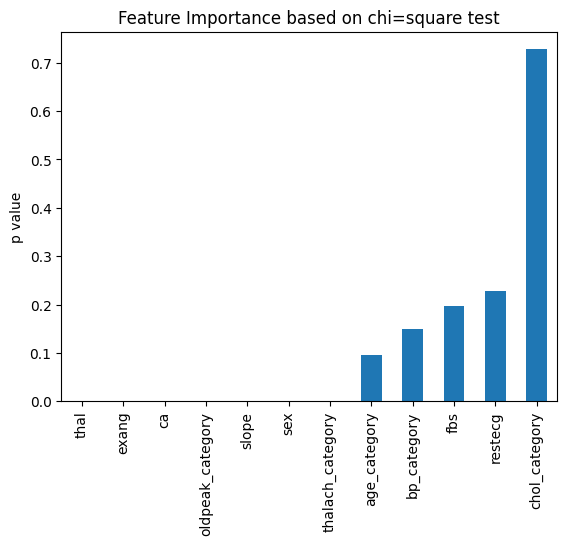

In [78]:
chi_ls=[]
for feature in X_train_fs.columns:
    c=pd.crosstab(y_train,X_train_fs[feature])
    p_values=chi2_contingency(c)[1]
    chi_ls.append(p_values)

pd.Series(chi_ls,index=X_train_fs.columns).sort_values(ascending=True).plot.bar(rot=90)
plt.ylabel('p value')
plt.title('Feature Importance based on chi=square test')

In [79]:
sel_=pd.Series(chi_ls,index=X_train_fs.columns).sort_values(ascending=True)[:10].index
sel_

Index(['thal', 'exang', 'ca', 'oldpeak_category', 'slope', 'sex',
       'thalach_category', 'age_category', 'bp_category', 'fbs'],
      dtype='object')

In [80]:
X_train_chi=X_train_fs[sel_]
X_test_chi=X_test_fs[sel_]


Training set
Logisitic Regression Training accuracy: 0.8066037735849056
Testing set
Logisitic Regression Testing accuracy: 0.7912087912087912


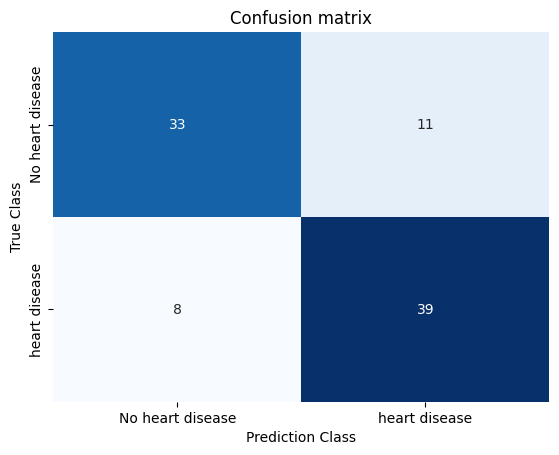

In [81]:
runLogisticRegreesion(X_train_chi,X_test_chi,y_train,y_test)

Training set
Logisitic Regression Regularization training accuracy: 0.8066037735849056
Testing set
Logisitic Regression Regularization testing accuracy : 0.7912087912087912
Confusion Metrics


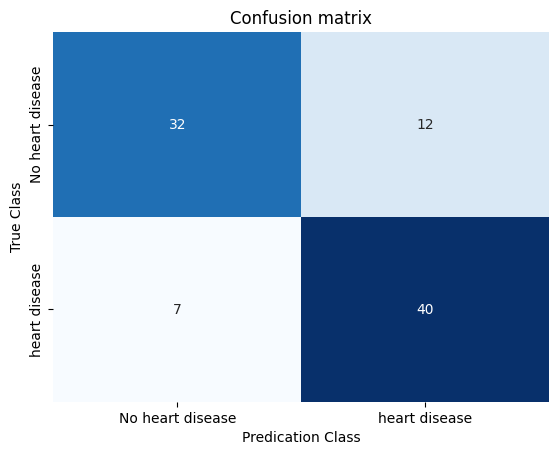

In [82]:
runLogisticRegressionRegularization(X_train_chi,X_test_chi,y_train,y_test)

In [83]:
logit=LogisticRegression(penalty='l2',solver='liblinear',random_state=0,max_iter=200)
kf=KFold(n_splits=5,shuffle=True,random_state=0)
clf=cross_validate(logit,X=X_train_chi,y=y_train,scoring='accuracy',cv=kf,return_train_score=True)
print('Logistic Regression Chi Feature Selection Train Accuracy:',np.mean(clf['train_score']),'+/-',np.std(clf['train_score']))
print('Logistic Regression chi Feature selection test accuracy:',np.mean(clf['test_score']),'+/-',np.std(clf['test_score']))

Logistic Regression Chi Feature Selection Train Accuracy: 0.8195683954054995 +/- 0.012207510270397709
Logistic Regression chi Feature selection test accuracy: 0.7971207087486157 +/- 0.05336637093311767


In [84]:
param_grid=dict(penalty=['l1','l2'],max_iter=[100,200,500,1000],C=[0.1,1,10])
clf=GridSearchCV(estimator=logit,cv=kf,param_grid=param_grid,scoring='accuracy')
search=clf.fit(X_train_chi,y_train)
search.best_params_

{'C': 10, 'max_iter': 100, 'penalty': 'l2'}

Training set
Decision Tree  Classifier Training accuracy: 0.9764150943396226
Test set
Descision Tree  Classifier Test accuracy: 0.6703296703296703


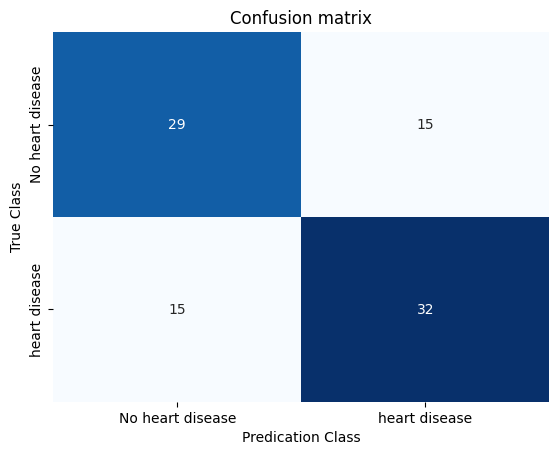

In [85]:
runDecisionTreeClassifier(X_train_chi,X_test_chi,y_train,y_test)

Training set
Random Forest Training accuracy : 0.9764150943396226
Test set
Random Forest Test accuracy: 0.7802197802197802


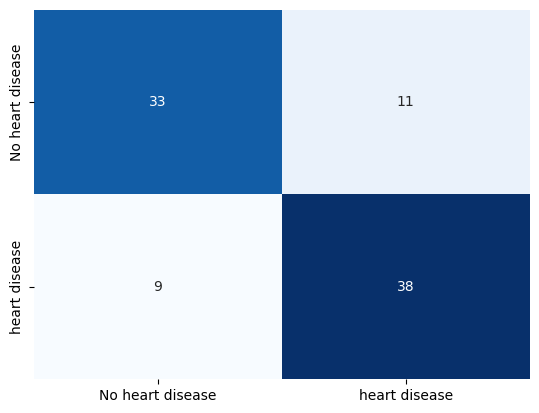

In [86]:
runRandomForestClassifier(X_train_chi,X_test_chi,y_train,y_test)

In [87]:
rfcv=RandomForestClassifier(n_estimators=100,random_state=0,max_depth=6)
kf=KFold(n_splits=5,random_state=0,shuffle=True)
clf=cross_validate(estimator=rfcv,X=X_train_chi,y=y_train,scoring='accuracy',cv=kf,return_train_score=True)
print('Random Forest CV training accuracy: ',np.mean(clf['train_score']),'+/-',np.std(clf['train_score']))
print('Random Forest CV test accuracy:',np.mean(clf['test_score']),'+/-',np.std(clf['test_score']))

Random Forest CV training accuracy:  0.9481239122868083 +/- 0.007748176861639043
Random Forest CV test accuracy: 0.7929125138427464 +/- 0.06232421973434651


In [88]:
param_grid=dict(n_estimators=[100,200,500,1000],max_depth=[4,6,8,10])
clf=GridSearchCV(estimator=rfcv,param_grid=param_grid,scoring='accuracy',cv=kf)
search=clf.fit(X_train_chi,y_train)
search.best_params_

{'max_depth': 4, 'n_estimators': 200}

#### 2.Wrapper Methods

#### 2.1 Step Forward Feature Selection

In [89]:
step_forward_fs=SFS(estimator=LogisticRegression(penalty='l2',solver='lbfgs',max_iter=100,random_state=0,C=1.0),
                   n_features_to_select=10,direction='forward',scoring='accuracy',cv=5,tol=None)
step_forward_fs=step_forward_fs.fit(X_train_scaled,y_train)
selected_features=step_forward_fs.get_feature_names_out()

Training set
Logisitic Regression Training accuracy: 0.8537735849056604
Testing set
Logisitic Regression Testing accuracy: 0.8241758241758241


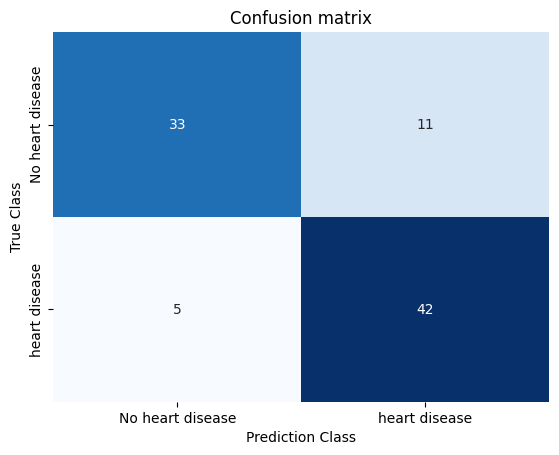

In [90]:
runLogisticRegreesion(X_train_scaled,X_test_scaled,y_train,y_test)

Training set
Logisitic Regression Training accuracy: 0.8584905660377359
Testing set
Logisitic Regression Testing accuracy: 0.8131868131868132


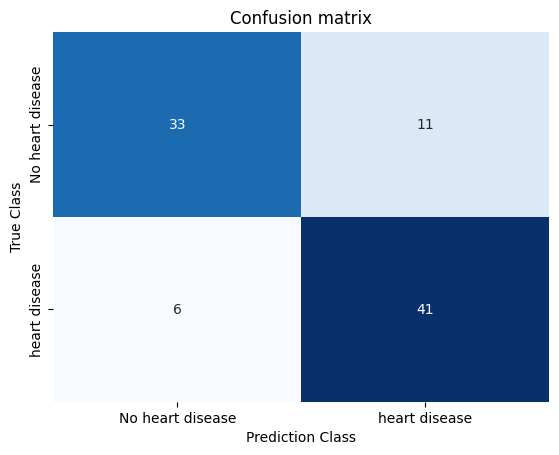

In [91]:
runLogisticRegreesion(X_train_scaled[selected_features],X_test_scaled[selected_features],y_train,y_test)

In [92]:
logit=LogisticRegression(penalty='l2',solver='liblinear',C=1.0,max_iter=100)
kf=KFold(n_splits=5,shuffle=True,random_state=0)
clf=cross_validate(estimator=logit,X=X_train_scaled[selected_features],y=y_train,scoring='accuracy',cv=kf,return_train_score=True)
print('Logistic Regression Step Forward Feature Selection train accracy',np.mean(clf['train_score']),'+/-',np.std(clf['train_score']))
print('Logisitic Regression Step Forward Feature Selection test accuracy:',np.mean(clf['test_score']),'+/-',np.std(clf['test_score']))

Logistic Regression Step Forward Feature Selection train accracy 0.8655760529063696 +/- 0.007636873778269596
Logisitic Regression Step Forward Feature Selection test accuracy: 0.8307862679955704 +/- 0.06853899238848654


In [93]:
param_grid=dict(penalty=['l1','l2'],C=[0.1,1.0,10],max_iter=[100,200,500,1000])
clf=GridSearchCV(estimator=logit,param_grid=param_grid,scoring='accuracy',cv=kf)
search=clf.fit(X_train_scaled[selected_features],y_train)
search.best_params_

{'C': 1.0, 'max_iter': 100, 'penalty': 'l2'}

In [94]:
step_forward_fs_rf=SFS(estimator=RandomForestClassifier(n_estimators=200,random_state=0,max_depth=4),
                      n_features_to_select=10,tol=None,scoring='accuracy',cv=5,direction='forward')
step_forward_fs_rf=step_forward_fs_rf.fit(X_train_stats,y_train)
selected_features=step_forward_fs_rf.get_feature_names_out()
selected_features

array(['sex', 'cp', 'chol', 'fbs', 'restecg', 'oldpeak', 'ca', 'thal',
       'age_category', 'thalach_category'], dtype=object)

Training set
Random Forest Training accuracy : 1.0
Test set
Random Forest Test accuracy: 0.8131868131868132


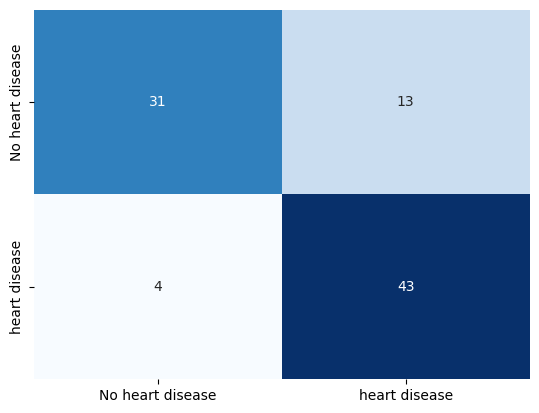

In [95]:
runRandomForestClassifier(X_train_stats,X_test_stats,y_train,y_test)

Training set
Random Forest Training accuracy : 1.0
Test set
Random Forest Test accuracy: 0.8241758241758241


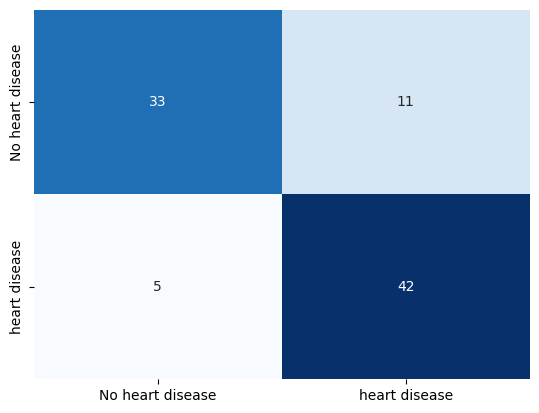

In [96]:
runRandomForestClassifier(X_train_stats[selected_features],X_test_stats[selected_features],y_train,y_test)

In [97]:
rfcv=RandomForestClassifier(n_estimators=100,max_depth=6,random_state=0)
kf=KFold(n_splits=5,shuffle=True,random_state=0)
clf=cross_validate(estimator=rfcv,X=X_train_stats[selected_features],y=y_train,cv=kf,scoring='accuracy',return_train_score=True)
print('Random Forest Step Forward  Feature Selection accuracy:',np.mean(clf['train_score']),'+/-',np.std(clf['train_score']))
print('Random Forest Step Forward Feature Selection accuracy:',np.mean(clf['test_score']),'+/-',np.std(clf['test_score']))

Random Forest Step Forward  Feature Selection accuracy: 0.9728646014618866 +/- 0.008053387055328471
Random Forest Step Forward Feature Selection accuracy: 0.8117386489479512 +/- 0.05017479066097583


In [98]:
param_grid=dict(n_estimators=[100,200,500,1000],max_depth=[4,6,10])
clf=GridSearchCV(estimator=rfcv,param_grid=param_grid,scoring='accuracy',cv=kf)
search=clf.fit(X_train_stats[selected_features],y_train)
search.best_params_

{'max_depth': 4, 'n_estimators': 100}

In [99]:
rfcv=RandomForestClassifier(n_estimators=100,max_depth=4)
kf=KFold(n_splits=5,random_state=0,shuffle=True)
clf=cross_validate(X=X_train_stats[selected_features],y=y_train,estimator=rfcv,cv=kf,return_train_score=True)
print('Best Param RandomForest Train Classifier',np.mean(clf['train_score']),'+/-',np.std(clf['train_score']))
print('Best Param RandomForest Test Classifier',np.mean(clf['test_score']),'+/-',np.std(clf['test_score']))

Best Param RandomForest Train Classifier 0.929258614688479 +/- 0.00822203448948354
Best Param RandomForest Test Classifier 0.8213732004429678 +/- 0.06583850016168867


#### Tensorflow 

In [100]:
model=models.Sequential()
model.add(keras.Input(shape=(X_train_scaled.shape[1],)))
model.add(layers.Dense(units=126,activation='relu'))
model.add(layers.Dense(units=64,activation='relu'))
model.add(layers.Dense(units=32,activation='relu'))
model.add(layers.Dense(units=1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
history=model.fit(X_train_stats,y_train,epochs=5,verbose=1,batch_size=100,validation_data=(X_test_stats,y_test))

Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 520ms/step - accuracy: 0.4316 - loss: 8.5372 - val_accuracy: 0.4945 - val_loss: 5.7736
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.4485 - loss: 5.5709 - val_accuracy: 0.5165 - val_loss: 1.7705
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.5222 - loss: 2.1378 - val_accuracy: 0.5055 - val_loss: 3.8198
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5397 - loss: 3.1275 - val_accuracy: 0.5165 - val_loss: 2.1932
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.5267 - loss: 2.0737 - val_accuracy: 0.5934 - val_loss: 0.9593


In [101]:
model=models.Sequential()
model.add(keras.Input(shape=(X_train_stats.shape[1],)))
model.add(layers.Dense(units=516,activation='relu'))
model.add(layers.Dense(units=126,activation='relu'))
model.add(layers.Dense(units=126,activation='relu'))
model.add(layers.Dense(units=64,activation='relu'))
model.add(layers.Dense(units=32,activation='relu'))
model.add(layers.Dense(units=1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer='rmsprop')
history=model.fit(X_train_stats,y_train,epochs=10,batch_size=100,validation_data=(X_test_stats,y_test),verbose=1)


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 359ms/step - accuracy: 0.5082 - loss: 5.2712 - val_accuracy: 0.5165 - val_loss: 6.0972
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5321 - loss: 3.4909 - val_accuracy: 0.4835 - val_loss: 4.8289
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.4439 - loss: 3.7970 - val_accuracy: 0.5165 - val_loss: 2.0279
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5090 - loss: 1.4292 - val_accuracy: 0.4835 - val_loss: 1.1423
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.5261 - loss: 1.2205 - val_accuracy: 0.5165 - val_loss: 0.8029
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.5804 - loss: 0.7169 - val_accuracy: 0.4835 - val_loss: 0.9486
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.4875 - loss: 1.0961 - val_accuracy: 0.5275 - val_loss: 0.7097
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.5694 - loss: 0.6805 - val_accuracy: 0.4945 - val_loss: 1.

Text(0.5, 0, 'Epoch')

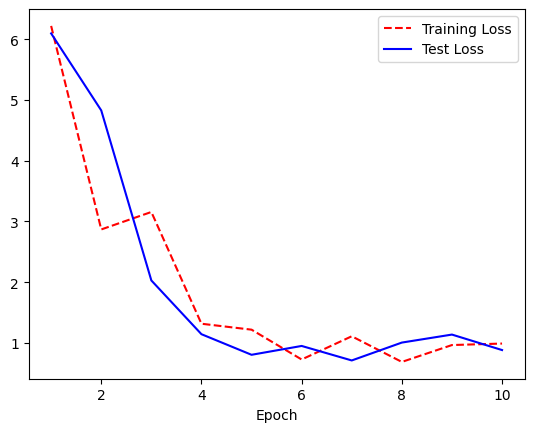

In [102]:
training_loss=history.history['loss']
test_loss=history.history['val_loss']
epochs_counts=range(1,len(training_loss)+1)
plt.plot(epochs_counts,training_loss,'r--')
plt.plot(epochs_counts,test_loss,'b-')
plt.legend(['Training Loss','Test Loss'])
plt.xlabel('Epoch')


#### Reduce Overfitting with Weight Regularization

In [103]:
model=models.Sequential()
model.add(keras.Input(shape=(X_train_stats.shape[1],)))
model.add(layers.Dense(units=516,activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dense(units=214,activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dense(units=164,activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dense(units=64,activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dense(units=32,activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dense(units=1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer='rmsprop')
history=model.fit(X_train_stats,y_train,verbose=1,epochs=10,validation_data=(X_test_stats,y_test))

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - accuracy: 0.4601 - loss: 11.4026 - val_accuracy: 0.6264 - val_loss: 6.0781
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5326 - loss: 6.1178 - val_accuracy: 0.5165 - val_loss: 5.6221
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3963 - loss: 5.8618 - val_accuracy: 0.5165 - val_loss: 5.0252
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6241 - loss: 4.8079 - val_accuracy: 0.5165 - val_loss: 4.7837
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4901 - loss: 4.5825 - val_accuracy: 0.5165 - val_loss: 4.3013
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5745 - loss: 4.0668 - val_accuracy: 0.5934 - val_loss: 3.7730
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5929 - loss: 3.7260 - val_accuracy: 0.7143 - val_loss: 3.4968
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6154 - loss: 3.5192 - val_accuracy: 0.5385 - val_loss: 3.278

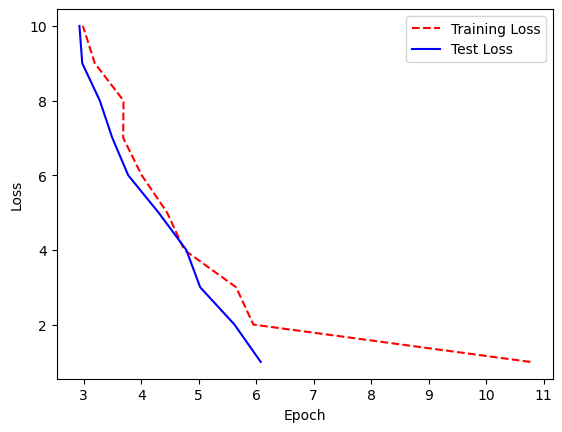

In [104]:
training_loss=history.history['loss']
test_loss=history.history['val_loss']
epoch_count=range(1,len(training_loss)+1)
plt.plot(training_loss,epoch_count,'r--')
plt.plot(test_loss,epoch_count,'b-')
plt.legend(['Training Loss','Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#### Learning Rate Scheduler

In [105]:
def scheduler(epoch,lr):
    if epoch<10:
        return lr
    else:
        return lr * math.exp(-0.1)

model=models.Sequential()
model.add(keras.Input(shape=(X_train_stats.shape[1],)))
model.add(layers.Dense(units=512,activation='relu'))
model.add(layers.Dense(units=264,activation='relu'))
model.add(layers.Dense(units=64,activation='relu'))
model.add(layers.Dense(units=32,activation='relu'))
model.add(layers.Dense(units=1,activation='sigmoid'))
model.compile(metrics=['accuracy'],optimizer='rmsprop',loss='binary_crossentropy')
round(model.optimizer.learning_rate,5)
callback=keras.callbacks.LearningRateScheduler(scheduler)
history=model.fit(X_train_stats,y_train,epochs=15,verbose=1,validation_data=(X_test_stats,y_test),callbacks=[callback])
round(model.optimizer.learning_rate,5)

Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.4706 - loss: 8.1191 - val_accuracy: 0.5165 - val_loss: 6.0500 - learning_rate: 0.0010
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5728 - loss: 3.1491 - val_accuracy: 0.5934 - val_loss: 0.6652 - learning_rate: 0.0010
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.4861 - loss: 2.2406 - val_accuracy: 0.5165 - val_loss: 3.1971 - learning_rate: 0.0010
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5378 - loss: 2.1606 - val_accuracy: 0.7033 - val_loss: 0.5637 - learning_rate: 0.0010
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.4830 - loss: 1.4849 - val_accuracy: 0.4835 - val_loss: 1.4076 - learning_rate: 0.0010
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.4896 - loss: 2.1060 - val_accuracy: 0.4945 - val_loss: 1.0870 - learning_rate: 0.0010
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5474 - loss: 1.2877 - val_accuracy: 0.5165

<tf.Tensor: shape=(), dtype=float32, numpy=0.0006099999882280827>

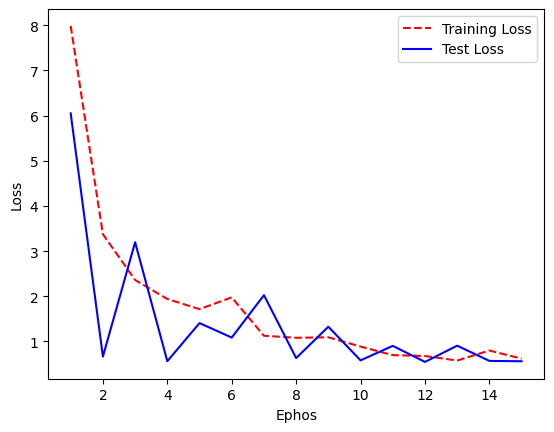

In [106]:
training_loss=history.history['loss']
test_loss=history.history['val_loss']
epoch_count=range(1,len(training_loss)+1)
plt.plot(epoch_count,training_loss,'r--')
plt.plot(epoch_count,test_loss,'b-')
plt.legend(['Training Loss','Test Loss'])
plt.xlabel('Ephos')
plt.ylabel('Loss')
plt.show()

#### Hyperparameter Tuning

In [107]:
def model_builder(hp):
    model=models.Sequential()
    model.add(keras.Input(shape=(X_train_stats.shape[1],)))

    hp_units=hp.Int('units',min_value=32,max_value=512,step=32)
    model.add(layers.Dense(units=hp_units,activation='relu'))
    model.add(layers.Dense(1))
    hp_learning_rate=hp.Choice('learning_rate',values=[1e-2,1e-3,1e-4])
    model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
    return model

In [108]:
tuner=kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='intro_to_kt'
)

Reloading Tuner from my_dir/intro_to_kt/tuner0.json


In [109]:
stop_early=keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

In [110]:
tuner.search(X_train_stats,y_train,epochs=15,validation_data=(X_test_stats,y_test),callbacks=[stop_early])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f'''
   The hyperparameter search is complete.The optimal number of units in the first densely-connected layer is {best_hps.get('units')} and 
   the optimal learning rate for the optimizer id {best_hps.get('learning_rate')}
''')


   The hyperparameter search is complete.The optimal number of units in the first densely-connected layer is 448 and 
   the optimal learning rate for the optimizer id 0.001



In [111]:
model=tuner.hypermodel.build(best_hps)
history=model.fit(X_train_stats,y_train,epochs=15,validation_data=(X_test_stats,y_test))
val_acc_per_epochs=history.history['val_accuracy']
best_epoch=val_acc_per_epochs.index(max(val_acc_per_epochs))+1
print('Best Epochs: %d' %(best_epoch,))

Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.5967 - loss: 6.4295 - val_accuracy: 0.5165 - val_loss: 7.7084
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5574 - loss: 7.0564 - val_accuracy: 0.5165 - val_loss: 7.7084
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5811 - loss: 6.6776 - val_accuracy: 0.5165 - val_loss: 7.7084
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5171 - loss: 7.6978 - val_accuracy: 0.5165 - val_loss: 7.7084
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5782 - loss: 6.7243 - val_accuracy: 0.5165 - val_loss: 7.7084
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.5679 - loss: 6.8883 - val_accuracy: 0.5165 - val_loss: 7.7084
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5667 - loss: 6.9080 - val_accuracy: 0.5165 - val_loss: 7.7084
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5611 - loss: 6.9973 - val_accuracy: 0.5165 - val_loss: 7.7084